August: Evolution of velocities in the canyon.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec

from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

In [2]:
print(animation.writers.list())

['imagemagick', 'ffmpeg_file', 'avconv_file', 'avconv', 'ffmpeg', 'imagemagick_file']


In [90]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

# ------------------------------------------------------------------------------------------------
def get_vars(dirname, depth_ind):
    #fname = "MCKNZ_1h_20170101_20170120_*"
    #y,x = slice(1,-50, None), slice(50,-50, None)
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = get_files(dirname, fname, 'grid_T')
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    filesW = get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        deptht = dsT.variables['deptht'][:]
        vozocrtx0 = dsU.variables['vozocrtx'][:,depth_ind,y,x]
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        vomecrty0 = dsV.variables['vomecrty'][:,depth_ind,y,x]
        sometauy = dsV.variables['sometauy'][:,0,0]
        vovecrtz0 = dsW.variables['vovecrtz'][:,depth_ind,y,x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,depth_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,depth_ind,y,x]
        tmask0 = dsM.variables['tmask'][0,depth_ind,y,x]
     
    umask = np.tile(umask0, (len(sozotaux),1, 1))
    vmask = np.tile(vmask0, (len(sozotaux),1, 1))
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))
    
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vozocrtx, sozotaux, vomecrty, sometauy, vovecrtz, deptht

In [91]:
depth_ind = 9
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

In [92]:
vozocrtx, sozotaux, vomecrty, sometauy, vovecrtz, deptht = get_vars(dirname, depth_ind)

In [105]:
def pcolormesh_velocity(ax, vel_array, time_ind, ttl):
    vel = vel_array[time_ind,...]
    vel_max = np.max(vel)
    vel_min = np.min(vel)
    vm = np.max([abs(vel_max), abs(vel_min)])
    xs = np.arange(vel_array.shape[-1])
    ys = np.arange(vel_array.shape[-2])

    cmap = plt.get_cmap(cm.RdBu_r)
    cmap.set_bad('wheat')
    C = ax.pcolormesh(xs, ys, vel, vmin = -1*vm, vmax = vm, cmap = cmap)
    ax.set_xlim([0, xs[-1]]); ax.set_ylim([0, ys[-1]])
    ax.set_xlabel('X Indices (Child)', fontsize=13)
    ax.set_ylabel('Y Indices (Child)', fontsize=13, labelpad=10)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_title(ttl, fontsize=20)
    
    if time_ind == 0:
        cbar = plt.colorbar(C, ax=ax, pad=0.1, orientation='horizontal')
        cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
    else:
        pass
    return ax

In [106]:
def plot_frames(ax1, ax2, ax3, axa, axb, time_ind, U_vel, V_vel, W_vel, stress):

    ax1 = pcolormesh_velocity(ax1, U_vel, time_ind, 'U Velocity [ms$^{-1}$]')
    ax2 = pcolormesh_velocity(ax2, V_vel, time_ind, 'V Velocity [ms$^{-1}$]')
    ax3 = pcolormesh_velocity(ax3, W_vel, time_ind, 'W Velocity [ms$^{-1}$]')

    axa.plot(stress[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_xlim([0, stress.shape[0]])
    axa.set_ylim(stress.min(), stress.max())
    axa.set_xlabel('Time [hrs]', fontsize=13)
    axa.set_title('Wind Stress [Nm$^{-2}$]', fontsize=13)
    axa.grid(color='gray', linestyle='-')
    axa.xaxis.set_ticks_position('none') 
    axa.yaxis.set_ticks_position('none') 
    for pos in ['top', 'bottom', 'right', 'left']:
        ax1.spines[pos].set_edgecolor('gray')
        ax2.spines[pos].set_edgecolor('gray')
        ax3.spines[pos].set_edgecolor('gray')
        axa.spines[pos].set_edgecolor('gray')
        axa.spines[pos].set_visible(False)   
    plt.tight_layout(h_pad=0.5, rect=[0, 0, 1, 0.96])  
    return

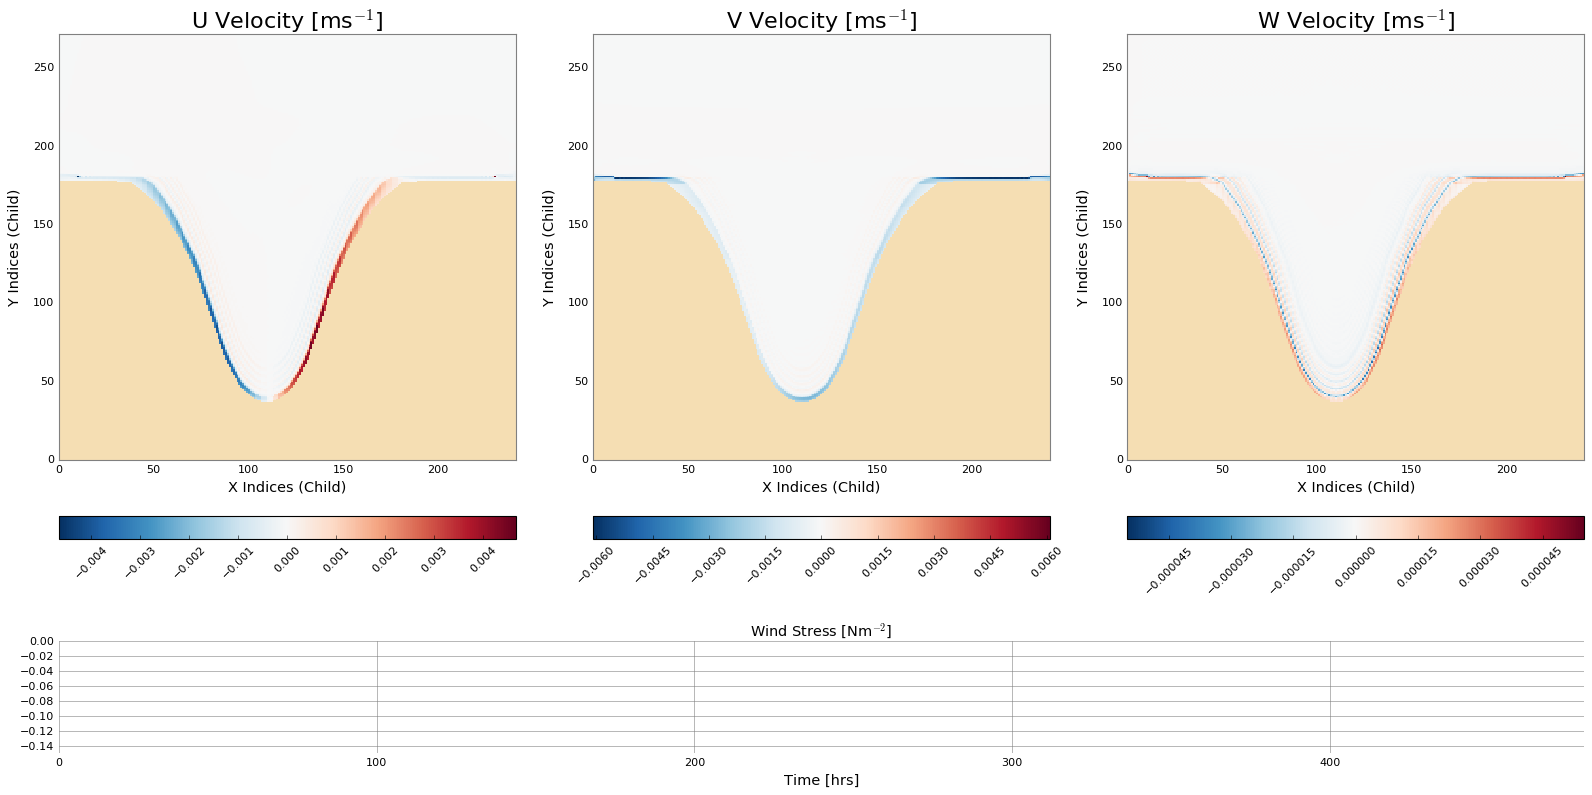

In [107]:
time_ind = 0

fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid((6, 12), (0, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((6, 12), (0, 4), colspan=4, rowspan=4, sharey=ax1)
ax3 = plt.subplot2grid((6, 12), (0, 8), colspan=4, rowspan=4, sharey=ax1)
axa = plt.subplot2grid((6, 12), (4, 0), colspan=12)

plot_frames(ax1, ax2, ax3, axa, axb, time_ind, vozocrtx, vomecrty, vovecrtz, sozotaux)

plt.show()

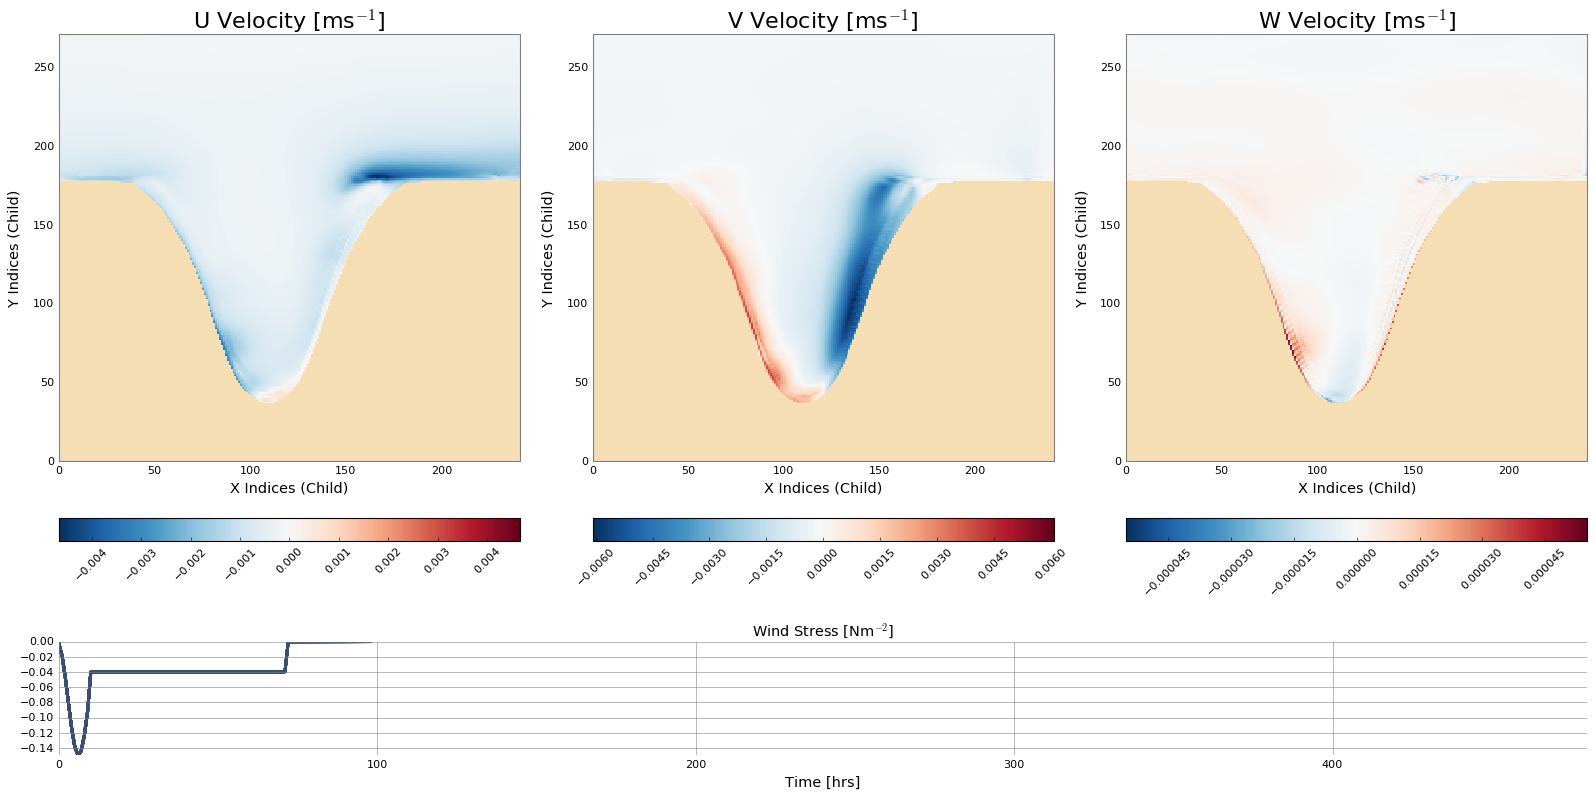

In [109]:
#13 mins for 100 frames
fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid((6, 12), (0, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((6, 12), (0, 4), colspan=4, rowspan=4, sharey=ax1)
ax3 = plt.subplot2grid((6, 12), (0, 8), colspan=4, rowspan=4, sharey=ax1)
axa = plt.subplot2grid((6, 12), (4, 0), colspan=12)

def init():
    return

def animate(time_ind):
    plot_frames(ax1, ax2, ax3, axa, axb, time_ind, vozocrtx, vomecrty, vovecrtz, sozotaux)
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=18000)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100,repeat=False)
anim.save('test.mp4', writer=writer)